**Author:** Andy Tzanidakis and the LINCC team \
**Last updated**: Aug 29, 2024

## Overview

In this notebook we will learn how to:

- Query and filter catalog data
- Compute time-series features for LSDB catalogs using `nested-dask`
- Plot light curves and periodograms

In [1]:
# Standard library imports
import os

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rcParams
import astropy.units as u
import dask
from dask.distributed import Client

# Local library-specific imports
import lsdb
from lsdb.core.search import BoxSearch, ConeSearch, PolygonSearch
from hipscat.inspection import plot_pixels
from hipscat.io.file_io import read_parquet_metadata

# Astropy
from astropy.timeseries import LombScargle

# Jupyter-specific settings and magic commands
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# Configuration settings
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
mpl.rcParams['axes.linewidth'] = 2

print(f'Version of lsdb is {lsdb.__version__}')

Version of lsdb is 0.3.0


In [2]:
catalogs_dir = "https://data.lsdb.io/unstable/"

# Gaia
gaia_path = f"{catalogs_dir}/gaia_dr3/gaia"
gaia_margin_path = f"{catalogs_dir}/gaia_dr3/gaia_10arcs"

# ZTF
ztf_object_path = f"{catalogs_dir}/ztf/ztf_dr14/"
ztf_source_path = f"{catalogs_dir}/ztf/ztf_zource/"

## Initialize Dask Client

Before we start building our workflow, let's initialize our Dask Client. The machine we're using has 8 cores and 25GiB of RAM so we'll decide to make good use of resources and go with 4 workers, each with 6 GiB of memory and 1 thread.

In [3]:
from dask.distributed import Client
client = Client(n_workers=4, memory_limit="6GiB", threads_per_worker=1)

## Get Gaia and ZTF

Let's read Gaia and ZTF (both lazily) as demonstrated in the first notebook.

In [4]:
%%time

# Load Gaia object table (with margins!)
gaia = lsdb.read_hipscat(gaia_path, columns=['ra', 'dec', 'parallax'], margin_cache=gaia_margin_path)

# Define a cone region of interest for ZTF
cone_search = ConeSearch(ra=132.8460000, dec=+11.8140000, radius_arcsec=5_000)

# Load ZTF object table
ztf = lsdb.read_hipscat(ztf_object_path, columns=['ra', 'dec', 'ps1_objid'], search_filter=cone_search)

# Load ZTF DR14 sources
ztf_sources = lsdb.read_hipscat(ztf_source_path, columns=['ra', 'dec', 'mjd', 'mag', 'magerr', 'band', 'ps1_objid', 'catflags'], search_filter=cone_search)

CPU times: user 1.79 s, sys: 306 ms, total: 2.09 s
Wall time: 5.71 s


## Create a sample object catalog

To create our sample let's crossmatch our ZTF region with Gaia with a 3-arcsecond radius.

In [5]:
_sample = ztf.crossmatch(gaia, radius_arcsec=3)

We can have a look at the object matches because this sample is relatively small and it fits in memory! 

In [6]:
%%time
_sample_computed = _sample.compute()
_sample_computed

CPU times: user 671 ms, sys: 84.4 ms, total: 755 ms
Wall time: 12.4 s


,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,ra_gaia,dec_gaia,parallax_gaia,_dist_arcsec
_hipscat_index,,,,,,,
1195635224533270528,133.2337,10.485653,120581332336983267,133.233718,10.485637,0.445226,0.085933
1195635242824630272,133.224741,10.485489,120581332247203053,133.224727,10.485452,0.621834,0.141202
1195635245353795584,133.225766,10.486782,120581332257664629,133.22577,10.486761,0.777203,0.077445
1195681424221405184,133.35658,10.524734,120631333565320137,133.356574,10.524717,0.959385,0.065692
1195681461315829760,133.379456,10.52903,120631333794875301,133.379471,10.529019,<NA>,0.067189
...,...,...,...,...,...,...,...
1216416656180379648,132.783272,13.19324,123831327832352378,132.783269,13.193228,<NA>,0.044713
1216420518253559808,132.632037,13.177743,123811326320263743,132.632043,13.177703,<NA>,0.144951
1216420530047942656,132.630009,13.182842,123811326300059917,132.630009,13.182812,0.450537,0.110055


In [7]:
print (f"Number of objects in crossmatch: {len(_sample_computed)}")

Number of objects in crossmatch: 36717


We selected a very small region of the sky - 5000 arcsec - and, as a result, our objects are contained in just a handful of pixels. In the following mollview of the pixel map, the gray color means that our sample catalog does not have coverage for that region in space.

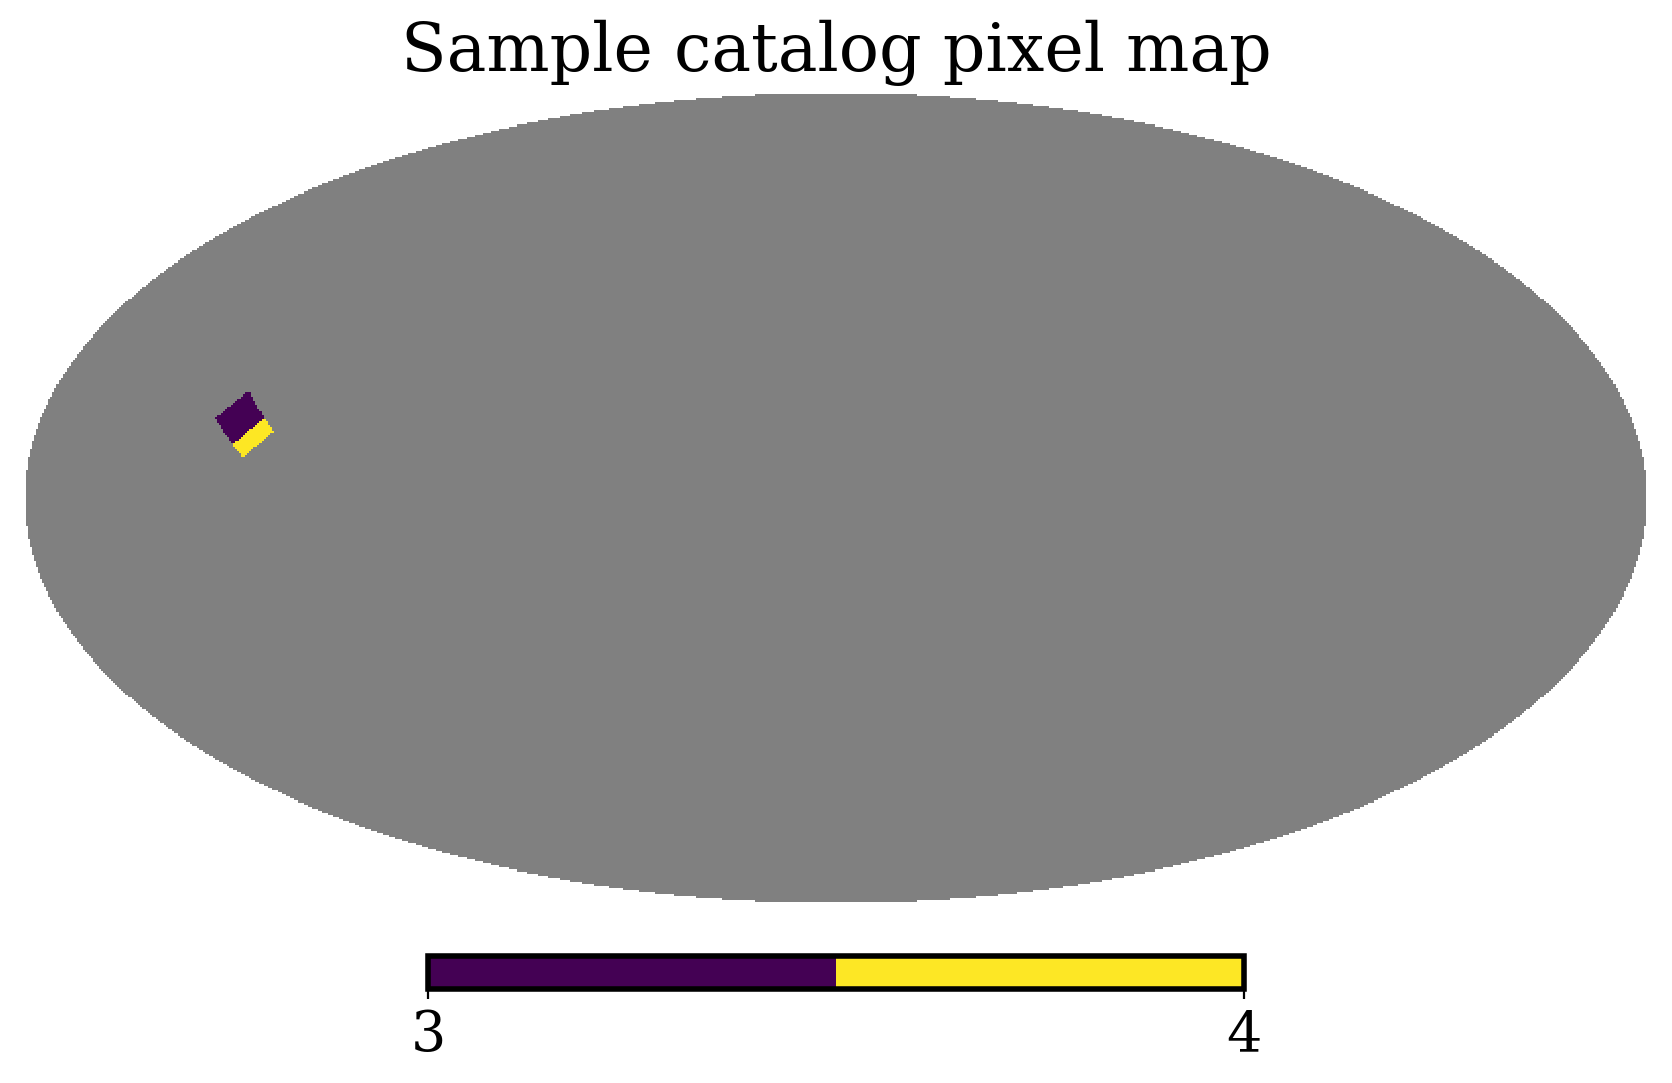

In [8]:
_sample.plot_pixels("Sample catalog pixel map")

## Fetch ZTF light curves for the samples

We will now perform a join operation between our sample objects and their respective ZTF sources. We will use the PanSTARRS object ID, as this is the index that both catalogs share. This is where `nested-dask` features come in handy. Under the hood, this `join_nested` call packs the time-domain data of each object as an additional column, which we decided to conveniently named `sources`.

In [9]:
_sources = _sample.join_nested(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid", nested_column_name="sources")
_sources = _sources._ddf # remove once have added LSDB wrappers for nested_dask
_sources

/opt/conda/envs/mwgaia-school/lib/python3.11/site-packages/lsdb/dask/join_catalog_data.py:334: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,ra_gaia,dec_gaia,parallax_gaia,_dist_arcsec,sources
npartitions=6,,,,,,,,
1194579801160024064,double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],"nested<ra: [double], dec: [double], mjd: [double], mag: [float], magerr: [float], band: [string], catflags: [int16]>"
1196831600973709312,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
1215971899390033920,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...


Note that we also get a warning stating that we are not using a margin catalog, as previously discussed in the first notebook.

## Filter on r-band

Our workflow will only operate on r-band data. We can apply the necessary cuts to our data to make sure that only light curves that have at least 10 observations in r-band will be considered!

In [10]:
# Query for observations in r-band
r_band = _sources.query("sources.band == 'r'")
# Calculate the number of observations
nobs = r_band.reduce(np.size, "sources.mjd", meta={0: int}).rename(columns={0: "nobs"})
# Get only those light curves with at least 10 observations
r_band = r_band[nobs["nobs"] > 10]

In [11]:
%%time
r_band.compute()

CPU times: user 1.35 s, sys: 1.15 s, total: 2.5 s
Wall time: 17.4 s


,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,ra_gaia,dec_gaia,parallax_gaia,_dist_arcsec,sources
_hipscat_index,,,,,,,,
1195635224533270528,133.2337,10.485653,120581332336983267,133.233718,10.485637,0.445226,0.085933,ra dec mjd m...
1195635242824630272,133.224741,10.485489,120581332247203053,133.224727,10.485452,0.621834,0.141202,ra dec mjd ...
1195635245353795584,133.225766,10.486782,120581332257664629,133.22577,10.486761,0.777203,0.077445,ra dec mjd ...
1195681424221405184,133.35658,10.524734,120631333565320137,133.356574,10.524717,0.959385,0.065692,ra dec mjd ...
1195681461315829760,133.379456,10.52903,120631333794875301,133.379471,10.529019,<NA>,0.067189,ra dec mjd ...
...,...,...,...,...,...,...,...,...
1216416656180379648,132.783272,13.19324,123831327832352378,132.783269,13.193228,<NA>,0.044713,ra dec mjd ...
1216420518253559808,132.632037,13.177743,123811326320263743,132.632043,13.177703,<NA>,0.144951,ra dec mjd ...
1216420530047942656,132.630009,13.182842,123811326300059917,132.630009,13.182812,0.450537,0.110055,ra dec mjd ...


## Extract features from light curves

We will now write custom analysis functions to compute features (statistics) on each light curve. These features (e.g. inverse Von Neumann, normalized excess variance) characterize the amount of outliers in the timeseries. They have been heavily used in literature, for example, to find variable stars.

In [12]:
# Column names for the custom features
cols = ['period', 'power', 'snr', 'mean', 'invNeumann', 'NormExcessVar', 'Nphot']

In [13]:
def compute_optimized_periodogram_grid(x0, oversampling_factor=5, nyquist_factor=3):
    """Computes an optimized periodogram frequency grid for a given time series. 

    Parameters:
    ----------
    x0 (array-like): The input time axis.
    oversampling_factor (int, optional): The oversampling factor for frequency grid. Default is 5.
    nyquist_factor (int, optional): The Nyquist factor for frequency grid. Default is 3.

    Returns:
    ----------
    array: The computed optimized periodogram frequency grid.
    """

    num_points = len(x0)
    baseline = np.max(x0) - np.min(x0)

    # Calculate the frequency resolution based on oversampling factor and baseline
    frequency_resolution = 1. / baseline / oversampling_factor

    # Calculate the number of frequencies and the frequency grid
    num_frequencies = int(0.5 * oversampling_factor * nyquist_factor * num_points)
    frequencies = frequency_resolution + frequency_resolution * np.arange(num_frequencies)

    return frequencies


def calc_invNeumann(t, mag, wstd):
    """Calculate the time-weighted inverse Von Neumann statistic.

    Parameters:
    ----------
    t (array-like): The input time axis.
    mag (array-like): The input magnitude axis.
    wstd (float): The weighted standard deviation of the magnitude.

    Returns:
    ----------
    float: The time-weighted inverse Von Neumann stat.

    Reference:
    ----------
        [1]: https://github.com/ZwickyTransientFacility/scope/blob/5a67134ab2cf41d0aab2c1b8920f63a67b48362e/tools/featureGeneration/lcstats.py#L69
    """
    dt = t[1:] - t[:-1]
    dm = mag[1:] - mag[:-1]

    w = (dt) ** -2  # inverse deltat weighted
    eta = np.sum(w * dm**2)
    eta /= np.sum(w) * wstd**2

    return eta**-1


def calc_NormExcessVar(mag, err, N, wmean):
    """Calculate the normalized excess variance statistic.

    Parameters:
    ----------
    mag (array-like): The input magnitude axis.
    err (array-like): The input magnitude error axis.
    N (int): The number of data points.
    wmean (float): The weighted mean of the magnitude.

    Returns:
    ----------
    float: The normalized excess variance statistic.

    Reference:
    ----------
        [1]: https://github.com/ZwickyTransientFacility/scope/blob/5a67134ab2cf41d0aab2c1b8920f63a67b48362e/tools/featureGeneration/lcstats.py#L69
    """
    stat = np.sum((mag - wmean) ** 2 - err**2)
    stat /= N * wmean**2
    return stat

def calc_features(time, mag, magerr, flag, band, custom_cols=cols):
    """Custom time-series features calculator.
    
    Parameters:
    ----------
    time (array-like): The input time axis.
    mag (array-like): The input magnitude axis.
    magerr (array-like): The input magnitude error axis.
    flag (array-like): The input flag axis.
    band (array-like): The input band axis.

    Returns:
    ----------
    pd.Series: The computed custom time-series features.
    """
    # Quality flags
    rmv = (flag == 0) & (~np.isnan(flag)) &  (band=='r') & (~np.isnan(mag)) & (~np.isnan(magerr)) & (magerr < 99) & (mag < 99)
    
    time_, mag_, magerr_ = time[rmv], mag[rmv], magerr[rmv]
    
    if len(time_)>0:
        lsp = LombScargle(time_,
                          mag_,
                          magerr_,
                          fit_mean=True,
                          center_data=True,
                          nterms=1, 
                          normalization='standard')
        
        # Determine optimal frequency grid given data...
        f_grid = compute_optimized_periodogram_grid(time,
                                                    oversampling_factor=0.3, nyquist_factor=100)
        power = lsp.power(f_grid)
        period = 1/f_grid
        snr = (max(power)-np.mean(power))/np.std(power) # snr of periodogram 

        # Other featues to compute 
        Neu = calc_invNeumann(time_, mag_, np.nanstd(mag_))
        ExcVar = calc_NormExcessVar(mag_, magerr_, len(mag_), np.nanstd(mag_))
        Nphot = len(time_)

        return pd.Series([period[np.argmax(power)], power[np.argmax(power)], snr, np.nanmean(mag_), Neu, ExcVar, Nphot],
                            index=custom_cols)  
    else:
        return pd.Series([0, 0, 0, 0, 0, 0, 0], index=custom_cols)

We can now apply the feature calculator function `calc_features` to each light curve.

In [14]:
features = r_band.reduce(
    calc_features,
    "sources.mjd",
    "sources.mag",
    "sources.magerr",
    "sources.catflags",
    "sources.band",
    meta={name: float for name in cols},
)
features

,period,power,snr,mean,invNeumann,NormExcessVar,Nphot
npartitions=6,,,,,,,
1194579801160024064,float64,float64,float64,float64,float64,float64,float64
1196831600973709312,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...
1215971899390033920,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...


Let's compute the result (bring it into memory). This will take a few minutes and display some expected runtime warnings.

In [15]:
%%time
features = features.compute()

/tmp/ipykernel_11385/47716357.py:48: RuntimeWarning: divide by zero encountered in power
/tmp/ipykernel_11385/47716357.py:49: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_11385/47716357.py:48: RuntimeWarning: divide by zero encountered in power
/tmp/ipykernel_11385/47716357.py:49: RuntimeWarning: invalid value encountered in multiply


CPU times: user 12.3 s, sys: 868 ms, total: 13.1 s
Wall time: 3min 54s


Let's inspect the results table and make some plots of our time series features.

In [16]:
# We have the results!
features

,period,power,snr,mean,invNeumann,NormExcessVar,Nphot
_hipscat_index,,,,,,,
1195635224533270528,0.964378,0.103166,6.912091,20.102354,0.355314,15500.346712,433.0
1195635242824630272,0.488478,0.037420,7.092345,19.525126,0.494461,38152.319545,554.0
1195635245353795584,0.498667,0.049012,12.941227,17.779547,0.507209,320777.617250,617.0
1195681424221405184,0.161282,0.033920,7.621750,17.070436,0.718703,539884.092086,619.0
1195681461315829760,0.964705,0.290928,4.212915,21.006584,0.946503,7447.698083,117.0
...,...,...,...,...,...,...,...
1216416656180379648,0.466748,0.310491,4.787793,20.987270,2.272826,4936.934409,123.0
1216420518253559808,0.436900,0.248063,4.802904,20.807816,2.141703,7106.396475,192.0
1216420530047942656,0.054961,0.029599,5.820457,18.014742,0.504425,251552.368146,662.0


In this figure we demonstrate the periods corresponding to highest power in the Lomb Scargle periodogram. Immediately, we can see a few overdensities of period, that are likely originating from the ZTF aliasing sampling cadence. Between those aliasing periods, those with high SNR score are possible periodic candidates that will require further investigation.

/opt/conda/envs/mwgaia-school/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


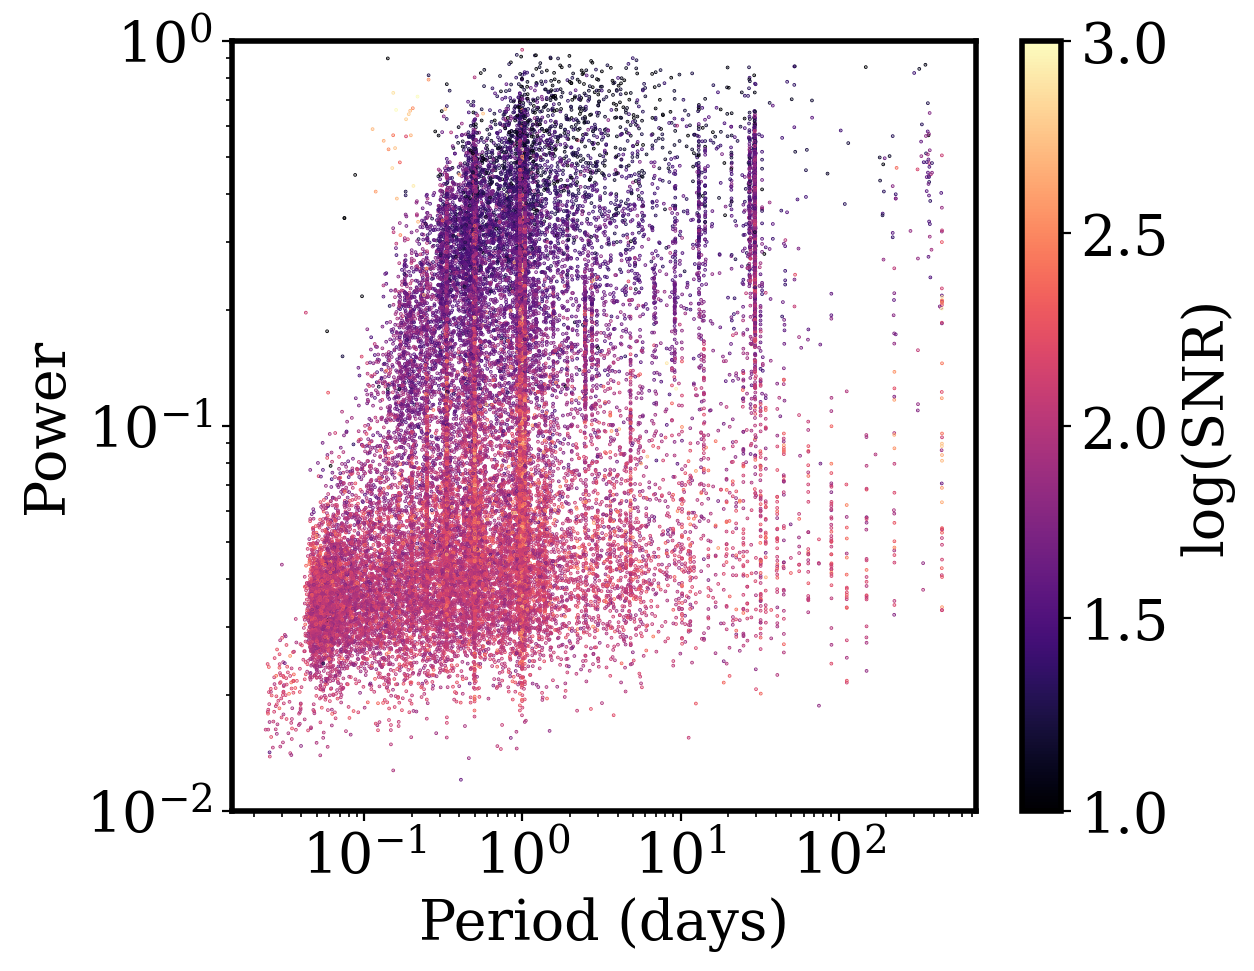

In [17]:
plt.figure(figsize=(6,5))
plt.scatter(features['period'], features['power'], s=0.1, c=np.log(features['snr']), cmap='magma', vmin=1, vmax=3)
plt.colorbar(label='log(SNR)')
plt.ylim(1e-2, 1e0)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.minorticks_on()

Below is the ZTF periodogram where also observe the aliasing sampling periods. For more information about periodograms please have a look at the [references](#References) section of this notebook.

![ZTF periodogram](https://raw.githubusercontent.com/lincc-frameworks/MWGaia-DN_Introductory_School/main/assets/ztf-periodogram.jpg)

## Plot light curve

We can now find a ZTF object with a high period SNR and that is bright, and plot the ZTF-r band light curve.

In [18]:
# Select good SNR candidate
features[(features['snr']>20) & (features['mean']<15)].head(5)

,period,power,snr,mean,invNeumann,NormExcessVar,Nphot
_hipscat_index,,,,,,,
1209433013427896320,0.217326,0.716238,22.941490,14.440848,32.595191,19957.636088,613.0
1209943734423126016,0.996238,0.352265,20.733923,14.714997,2.917700,276017.138205,660.0
1215978709064876032,0.787238,0.397726,24.705761,14.533778,2.560923,217372.218784,1137.0
1215995140963827712,0.499223,0.169420,22.203818,12.941055,1.087141,804302.105806,617.0
1216238507677188096,0.996239,0.098632,21.619643,14.316386,0.712379,941602.836716,1145.0


In [19]:
# Select a light curve with high SNR
object_id = 1209433013427896320 # hips index
best_period = 0.217326 # (in days) best period from the above table

In [20]:
# Compute the light curve magnitudes
lc_object = r_band.loc[object_id].query("sources.band == 'r'")
lc = lc_object.sources.compute().iloc[0]

When we fold the light curve on the correct period the scatter between the points is minimized, and therefore, the observations line up.

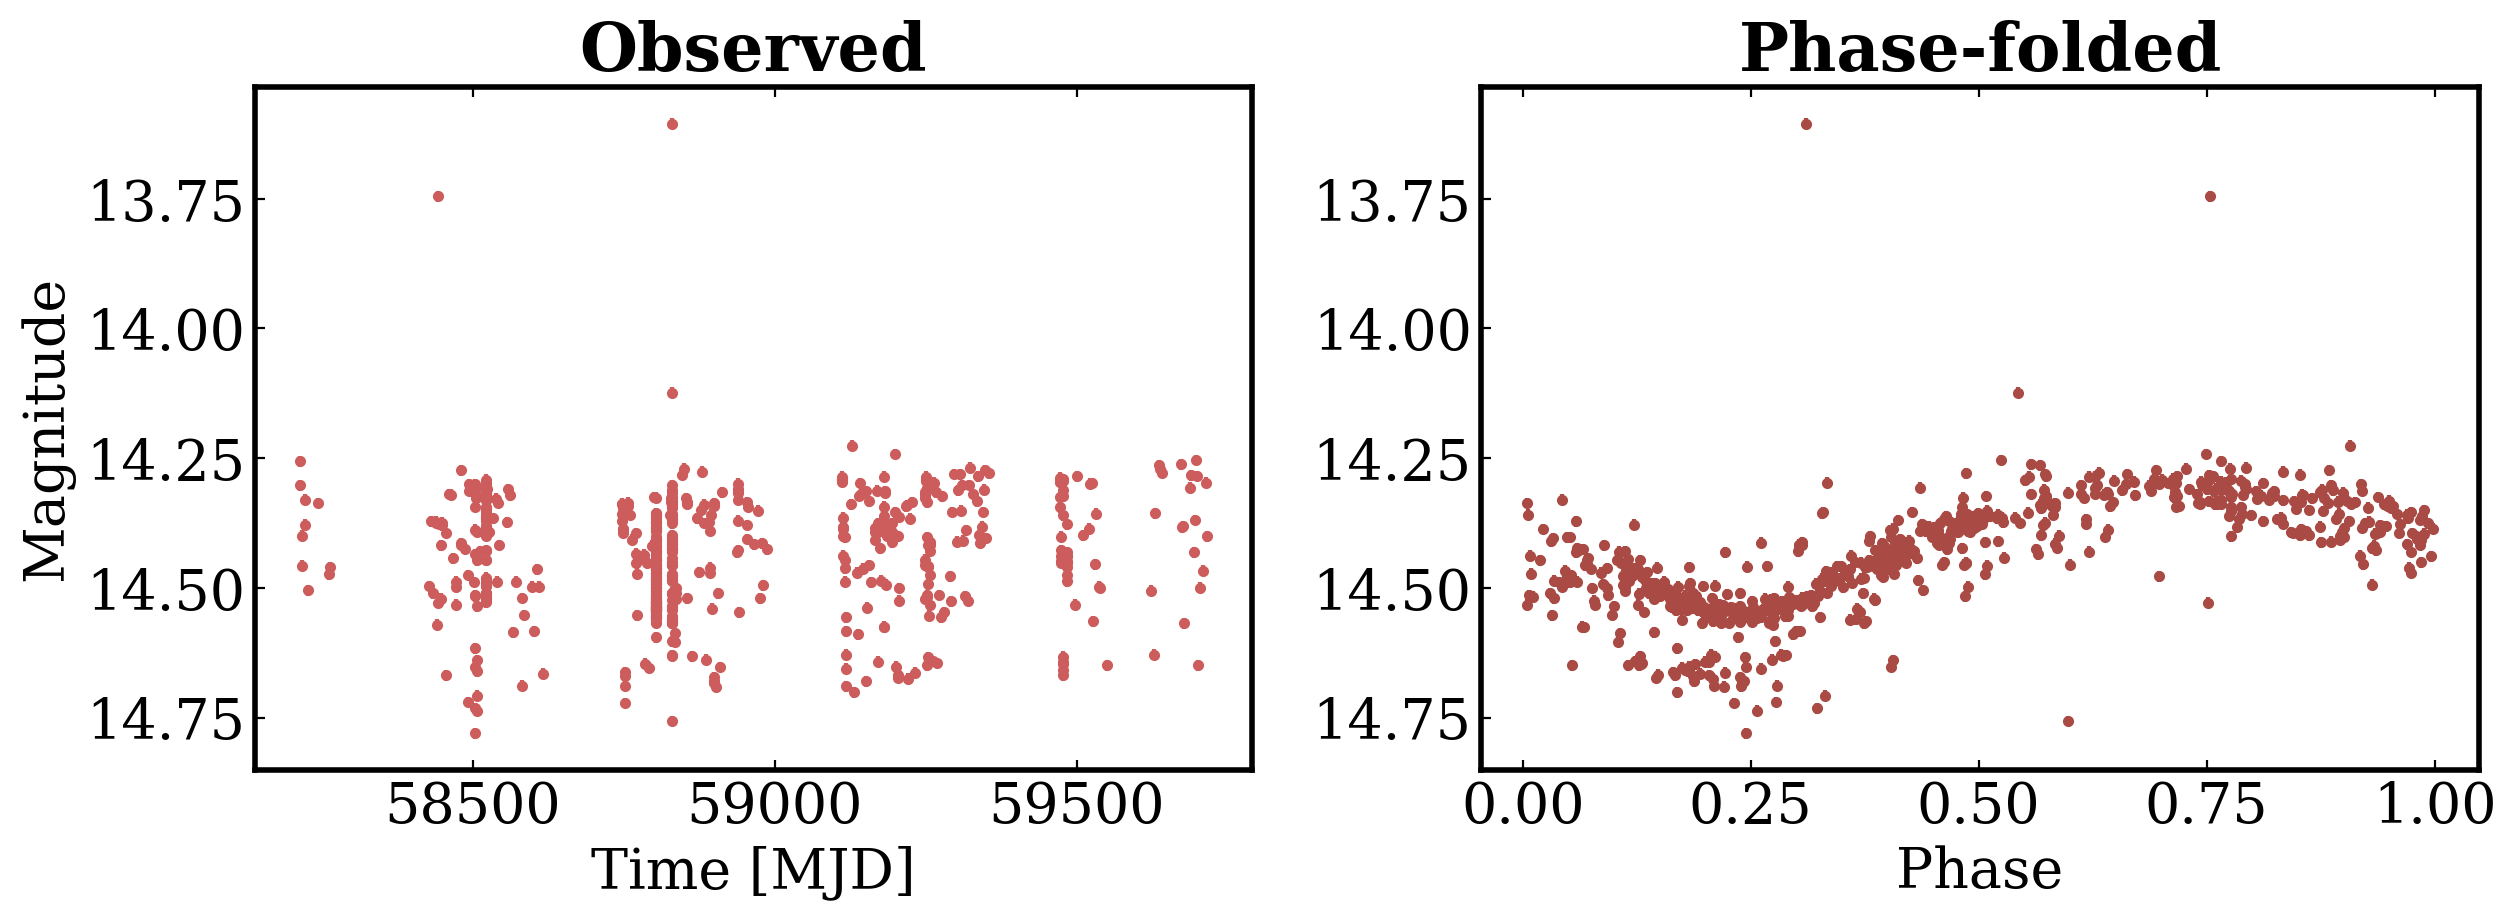

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

ax[0].errorbar(
    lc["mjd"],
    lc["mag"],
    yerr=lc["magerr"], 
    fmt='.',
    color='indianred'
)

ax[1].errorbar((lc["mjd"].to_numpy()%best_period)/best_period, lc["mag"],
                yerr=lc["magerr"], fmt='.', color='#AA4A44')
ax[1].set_xlabel('Phase')
ax[0].set_xlabel('Time [MJD]')
ax[1].tick_params(axis='x', which='both', bottom=True, top=True, direction='in')
ax[0].tick_params(axis='x', which='both', bottom=True, top=True, direction='in')
ax[1].tick_params(axis='y', which='both', bottom=True, top=True, direction='in')
ax[0].tick_params(axis='y', which='both', bottom=True, top=True, direction='in')
ax[0].set_ylabel('Magnitude')
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_title("Observed", weight='bold')
ax[1].set_title("Phase-folded", weight='bold')

plt.tight_layout()

## Extra topics

### Existing feature extractors

In this notebook we demonstrated how you can define and use your own custom functions to operate on light curves. There are also third-party packages that extract common features so that you don't have to implement these operations yourself (e.g. [`light-curve`](https://github.com/light-curve/light-curve-python) package). For more information please read the following [tutorial](https://nested-dask.readthedocs.io/en/latest/tutorials/work_with_lsdb.html#Extract-features-from-ZTF-light-curves).

In [22]:
# Release allocated resources!
client.close()

### References

[1]: https://iopscience.iop.org/article/10.3847/1538-4365/aab766 \
[2]: https://academic.oup.com/mnras/article/505/2/2954/6284767 \
[3]: https://www.astroml.org/gatspy/periodic/lomb_scargle_multiband.html \
[4]: Science with ZTF: https://iopscience.iop.org/article/10.1088/1538-3873/ab006c/pdf \
[5]: https://www.youtube.com/watch?v=2EwtD3Nhazs